<a href="https://colab.research.google.com/github/JangAY/TugasAkhir_PCD/blob/main/Salt_and_Pepper_Noise_Removal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -U scikit-learn


In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr




In [4]:
# Fungsi untuk menghitung Mean Absolute Error (MAE)
def mean_absolute_error(image1, image2):
    return np.mean(np.abs(image1 - image2))


In [5]:

# Fungsi Adaptive Median Filter (tidak berubah)
def adaptive_median_filter(image, max_window_size=7):
    padded_image = np.pad(image, max_window_size, mode='constant', constant_values=0)
    result = np.copy(image)

    rows, cols = image.shape
    for i in range(rows):
        for j in range(cols):
            window_size = 3
            while window_size <= max_window_size:
                half = window_size // 2
                window = padded_image[i:i + window_size, j:j + window_size]
                min_val = np.min(window)
                max_val = np.max(window)
                med_val = np.median(window)

                if min_val < med_val < max_val:
                    if not (image[i, j] == min_val or image[i, j] == max_val):
                        result[i, j] = image[i, j]
                    else:
                        result[i, j] = med_val
                    break
                window_size += 2
    return result



In [6]:
# Fungsi Edge-Preserving Regularization (tidak berubah)
def edge_preserving_regularization(image, noise_candidates):
    result = np.copy(image)
    for i in range(1, image.shape[0] - 1):
        for j in range(1, image.shape[1] - 1):
            if noise_candidates[i, j]:  # Jika piksel adalah noise
                local_patch = image[i-1:i+2, j-1:j+2]
                result[i, j] = np.mean(local_patch)  # Regularisasi sederhana
    return result



In [7]:
# Fungsi untuk menambahkan noise salt-and-pepper (tidak berubah)
def add_salt_and_pepper_noise(image, amount=0.1):
    noisy_image = np.copy(image)
    num_noisy = int(amount * image.size)
    coords = [np.random.randint(0, i - 1, num_noisy) for i in image.shape]
    noisy_image[coords] = np.random.choice([0, 255], num_noisy)
    return noisy_image


In [8]:

# Simulasi
original_image = cv2.imread("/content/drive/MyDrive/Foto/tb_pcd/Lena.bmp", cv2.IMREAD_GRAYSCALE)
original_image = cv2.resize(original_image, (256, 256))



In [9]:
def add_salt_and_pepper_noise(image, amount=0.1):
    """
    Menambahkan noise salt-and-pepper pada gambar.
    :param image: Gambar input (grayscale).
    :param amount: Proporsi piksel yang akan terpengaruh noise (0-1).
    :return: Gambar dengan noise salt-and-pepper.
    """
    noisy_image = np.copy(image)
    num_noisy = int(amount * image.size)

    # Tentukan koordinat piksel yang terkena noise
    coords = (np.random.randint(0, image.shape[0], num_noisy),
              np.random.randint(0, image.shape[1], num_noisy))

    # Terapkan noise (0 untuk "pepper", 255 untuk "salt")
    noisy_image[coords] = np.random.choice([0, 255], num_noisy)
    return noisy_image


In [10]:
# Menambahkan noise
noise_level = 0.3
noisy_image = add_salt_and_pepper_noise(original_image, noise_level)

# Terapkan Adaptive Median Filter
amf_result = adaptive_median_filter(noisy_image)

# Deteksi noise candidates
noise_candidates = noisy_image != amf_result

# Terapkan Edge-Preserving Regularization
epr_result = edge_preserving_regularization(amf_result, noise_candidates)

# Evaluasi metrik
psnr_amf = psnr(original_image, amf_result, data_range=255)
psnr_epr = psnr(original_image, epr_result, data_range=255)
mae_amf = mean_absolute_error(original_image, amf_result)
mae_epr = mean_absolute_error(original_image, epr_result)


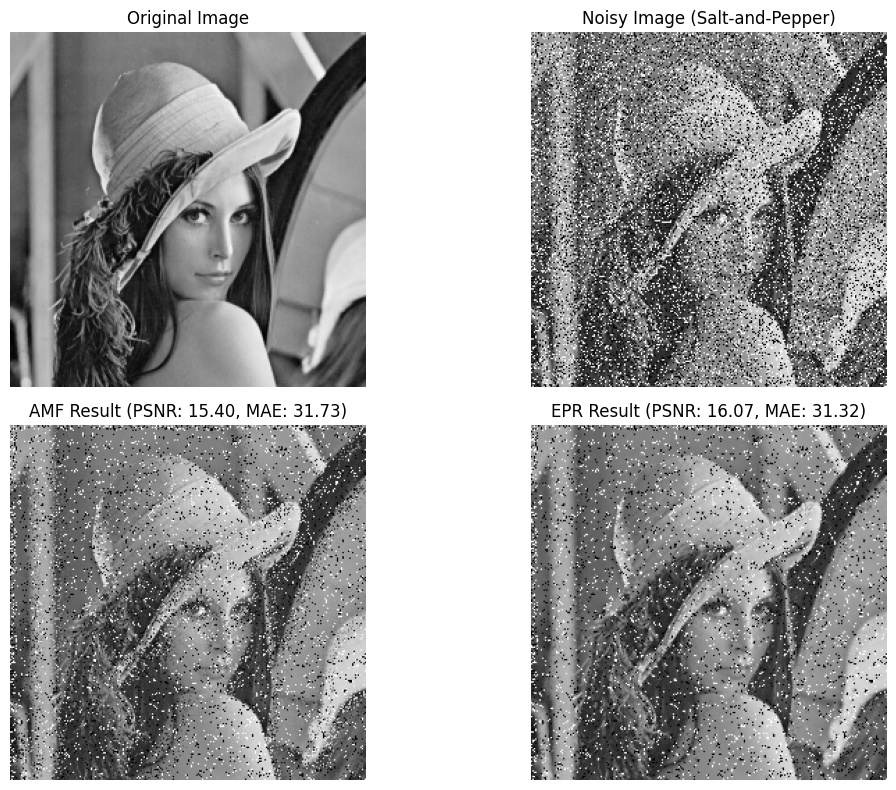

In [11]:

# Visualisasi hasil
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.title("Original Image")
plt.imshow(original_image, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title("Noisy Image (Salt-and-Pepper)")
plt.imshow(noisy_image, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.title(f"AMF Result (PSNR: {psnr_amf:.2f}, MAE: {mae_amf:.2f})")
plt.imshow(amf_result, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.title(f"EPR Result (PSNR: {psnr_epr:.2f}, MAE: {mae_epr:.2f})")
plt.imshow(epr_result, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

                                 Method  PSNR (dB)        MAE
0          Adaptive Median Filter (AMF)  15.400751  31.731796
1  Edge-Preserving Regularization (EPR)  16.068320  31.319611


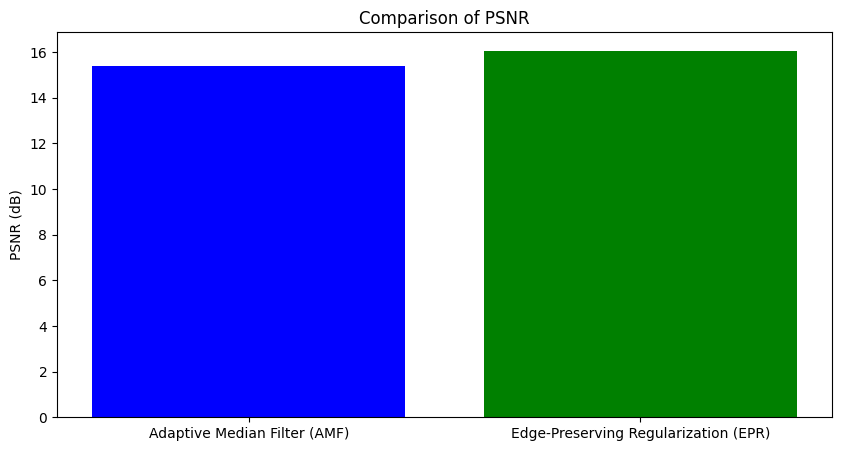

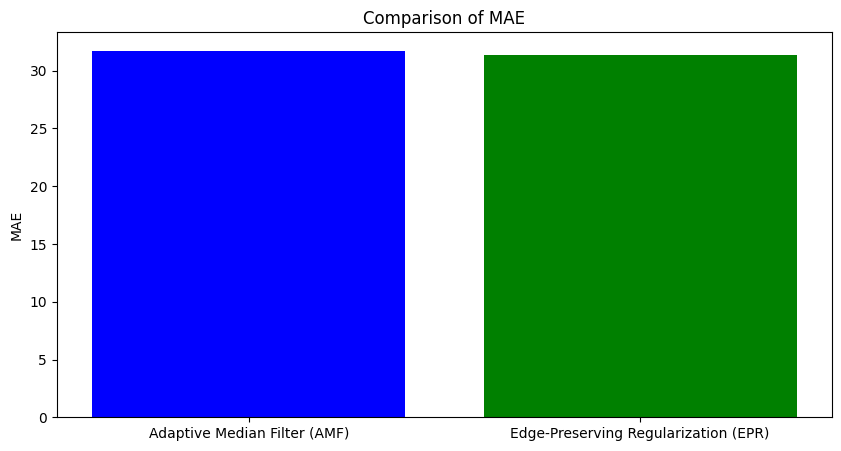

In [12]:
import pandas as pd

# Evaluasi metrik untuk AMF dan EPR
psnr_amf = psnr(original_image, amf_result, data_range=255)
psnr_epr = psnr(original_image, epr_result, data_range=255)
mae_amf = mean_absolute_error(original_image, amf_result)
mae_epr = mean_absolute_error(original_image, epr_result)

# Tabel hasil perbandingan
results = pd.DataFrame({
    "Method": ["Adaptive Median Filter (AMF)", "Edge-Preserving Regularization (EPR)"],
    "PSNR (dB)": [psnr_amf, psnr_epr],
    "MAE": [mae_amf, mae_epr]
})

# Cetak tabel hasil
print(results)

# Simpan tabel ke file CSV (opsional)
results.to_csv("method_comparison_results.csv", index=False)

# Visualisasi perbandingan
import matplotlib.pyplot as plt

# Bar plot untuk PSNR
plt.figure(figsize=(10, 5))
plt.bar(results["Method"], results["PSNR (dB)"], color=['blue', 'green'])
plt.title("Comparison of PSNR")
plt.ylabel("PSNR (dB)")
plt.show()

# Bar plot untuk MAE
plt.figure(figsize=(10, 5))
plt.bar(results["Method"], results["MAE"], color=['blue', 'green'])
plt.title("Comparison of MAE")
plt.ylabel("MAE")
plt.show()


In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr

# Fungsi Edge-Preserving Regularization dengan parameter beta
def edge_preserving_regularization_beta(image, noise_candidates, beta):
    result = np.copy(image)
    for i in range(1, image.shape[0] - 1):
        for j in range(1, image.shape[1] - 1):
            if noise_candidates[i, j]:
                local_patch = image[i-1:i+2, j-1:j+2]
                result[i, j] = np.mean(local_patch) + beta * np.std(local_patch)
    return result

# Load gambar dengan validasi
lena_image = cv2.imread("/content/drive/MyDrive/Foto/tb_pcd/Lena.bmp", cv2.IMREAD_GRAYSCALE)
bridge_image = cv2.imread("/content/drive/MyDrive/Foto/tb_pcd/bridge.jpg", cv2.IMREAD_GRAYSCALE)

if lena_image is None:
    raise FileNotFoundError("File 'lena.bmp' tidak ditemukan.")
if bridge_image is None:
    raise FileNotFoundError("File 'bridge.jpg' tidak ditemukan.")

# Resize gambar
lena_image = cv2.resize(lena_image, (256, 256))
bridge_image = cv2.resize(bridge_image, (256, 256))

# Tambahkan noise dan proses seperti sebelumnya...


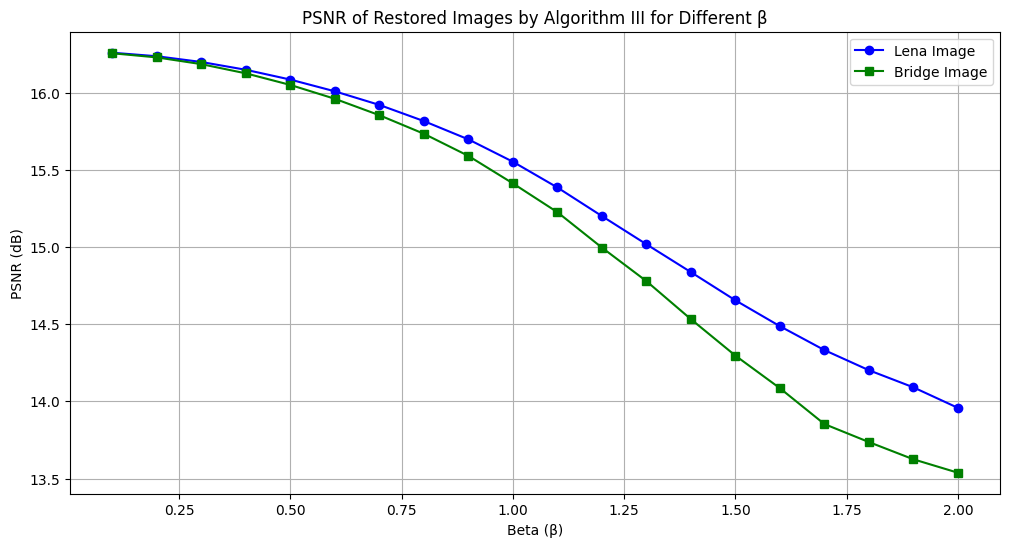

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr

# Fungsi Adaptive Median Filter
def adaptive_median_filter(image, max_window_size=7):
    padded_image = np.pad(image, max_window_size, mode='constant', constant_values=0)
    result = np.copy(image)

    rows, cols = image.shape
    for i in range(rows):
        for j in range(cols):
            window_size = 3
            while window_size <= max_window_size:
                half = window_size // 2
                window = padded_image[i:i + window_size, j:j + window_size]
                min_val = np.min(window)
                max_val = np.max(window)
                med_val = np.median(window)

                if min_val < med_val < max_val:
                    if not (image[i, j] == min_val or image[i, j] == max_val):
                        result[i, j] = image[i, j]
                    else:
                        result[i, j] = med_val
                    break
                window_size += 2
    return result

# Fungsi Edge-Preserving Regularization dengan parameter beta
def edge_preserving_regularization_beta(image, noise_candidates, beta):
    result = np.copy(image)
    for i in range(1, image.shape[0] - 1):
        for j in range(1, image.shape[1] - 1):
            if noise_candidates[i, j]:  # Jika piksel adalah noise
                local_patch = image[i-1:i+2, j-1:j+2]
                result[i, j] = np.mean(local_patch) + beta * np.std(local_patch)
    return result

# Fungsi untuk menambahkan noise salt-and-pepper
def add_salt_and_pepper_noise(image, amount=0.1):
    noisy_image = np.copy(image)
    num_noisy = int(amount * image.size)
    coords = (np.random.randint(0, image.shape[0], num_noisy),
              np.random.randint(0, image.shape[1], num_noisy))
    noisy_image[coords] = np.random.choice([0, 255], num_noisy)
    return noisy_image

# Load gambar Lena dan Bridge
lena_image = cv2.imread("/content/drive/MyDrive/Foto/tb_pcd/Lena.bmp", cv2.IMREAD_GRAYSCALE)
bridge_image = cv2.imread("/content/drive/MyDrive/Foto/tb_pcd/bridge.jpg", cv2.IMREAD_GRAYSCALE)

if lena_image is None:
    raise FileNotFoundError("File 'lena.bmp' tidak ditemukan.")
if bridge_image is None:
    raise FileNotFoundError("File 'bridge.jpg' tidak ditemukan.")

# Resize gambar
lena_image = cv2.resize(lena_image, (256, 256))
bridge_image = cv2.resize(bridge_image, (256, 256))

# Tambahkan noise salt-and-pepper ke gambar
noise_level = 0.3
lena_noisy = add_salt_and_pepper_noise(lena_image, noise_level)
bridge_noisy = add_salt_and_pepper_noise(bridge_image, noise_level)

# Terapkan AMF ke kedua gambar
lena_amf = adaptive_median_filter(lena_noisy)
bridge_amf = adaptive_median_filter(bridge_noisy)

# Deteksi noise candidates
lena_noise_candidates = lena_noisy != lena_amf
bridge_noise_candidates = bridge_noisy != bridge_amf

# Nilai beta yang akan diuji
beta_values = np.linspace(0.1, 2.0, 20)

# Simpan PSNR untuk setiap beta
lena_psnr = []
bridge_psnr = []

for beta in beta_values:
    lena_restored = edge_preserving_regularization_beta(lena_amf, lena_noise_candidates, beta)
    bridge_restored = edge_preserving_regularization_beta(bridge_amf, bridge_noise_candidates, beta)

    lena_psnr.append(psnr(lena_image, lena_restored, data_range=255))
    bridge_psnr.append(psnr(bridge_image, bridge_restored, data_range=255))

# Plot hasil PSNR untuk Lena dan Bridge
plt.figure(figsize=(12, 6))
plt.plot(beta_values, lena_psnr, label="Lena Image", marker='o', color='blue')
plt.plot(beta_values, bridge_psnr, label="Bridge Image", marker='s', color='green')
plt.title("PSNR of Restored Images by Algorithm III for Different β")
plt.xlabel("Beta (β)")
plt.ylabel("PSNR (dB)")
plt.legend()
plt.grid()
plt.show()


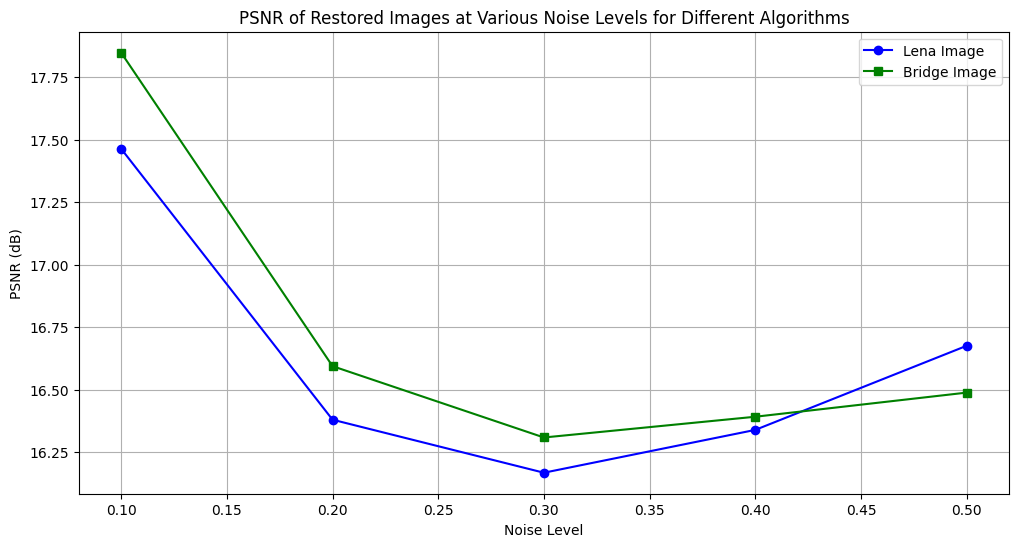

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr

# Fungsi untuk menambahkan noise salt-and-pepper dengan level yang lebih bervariasi
def add_salt_and_pepper_noise(image, amount=0.1):
    noisy_image = np.copy(image)
    num_noisy = int(amount * image.size)
    coords = (np.random.randint(0, image.shape[0], num_noisy),
              np.random.randint(0, image.shape[1], num_noisy))
    noisy_image[coords] = np.random.choice([0, 255], num_noisy)
    return noisy_image

# Fungsi Adaptive Median Filter
def adaptive_median_filter(image, max_window_size=7):
    padded_image = np.pad(image, max_window_size, mode='constant', constant_values=0)
    result = np.copy(image)

    rows, cols = image.shape
    for i in range(rows):
        for j in range(cols):
            window_size = 3
            while window_size <= max_window_size:
                half = window_size // 2
                window = padded_image[i:i + window_size, j:j + window_size]
                min_val = np.min(window)
                max_val = np.max(window)
                med_val = np.median(window)

                if min_val < med_val < max_val:
                    if not (image[i, j] == min_val or image[i, j] == max_val):
                        result[i, j] = image[i, j]
                    else:
                        result[i, j] = med_val
                    break
                window_size += 2
    return result

# Fungsi Edge-Preserving Regularization dengan parameter beta
def edge_preserving_regularization_beta(image, noise_candidates, beta):
    result = np.copy(image)
    for i in range(1, image.shape[0] - 1):
        for j in range(1, image.shape[1] - 1):
            if noise_candidates[i, j]:  # Jika piksel adalah noise
                local_patch = image[i-1:i+2, j-1:j+2]
                result[i, j] = np.mean(local_patch) + beta * np.std(local_patch)
    return result

# Load gambar Lena dan Bridge
lena_image = cv2.imread("/content/drive/MyDrive/Foto/tb_pcd/Lena.bmp", cv2.IMREAD_GRAYSCALE)
bridge_image = cv2.imread("/content/drive/MyDrive/Foto/tb_pcd/bridge.jpg", cv2.IMREAD_GRAYSCALE)

if lena_image is None:
    raise FileNotFoundError("File 'lena.bmp' tidak ditemukan.")
if bridge_image is None:
    raise FileNotFoundError("File 'bridge.jpg' tidak ditemukan.")

# Resize gambar
lena_image = cv2.resize(lena_image, (256, 256))
bridge_image = cv2.resize(bridge_image, (256, 256))

# Noise levels for visualization
noise_levels = np.linspace(0.1, 0.5, 5)  # Varying noise levels

# Initialize lists to store PSNR values for each image and noise level
lena_psnr_noise = []
bridge_psnr_noise = []

# Loop over different noise levels
for noise_level in noise_levels:
    # Tambahkan noise ke gambar
    lena_noisy = add_salt_and_pepper_noise(lena_image, noise_level)
    bridge_noisy = add_salt_and_pepper_noise(bridge_image, noise_level)

    # Terapkan AMF ke gambar yang bernoise
    lena_amf = adaptive_median_filter(lena_noisy)
    bridge_amf = adaptive_median_filter(bridge_noisy)

    # Deteksi noise candidates
    lena_noise_candidates = lena_noisy != lena_amf
    bridge_noise_candidates = bridge_noisy != bridge_amf

    # Nilai beta untuk mengembalikan gambar
    beta_values = np.linspace(0.1, 2.0, 5)

    # Simpan PSNR untuk setiap beta
    lena_psnr = []
    bridge_psnr = []

    for beta in beta_values:
        lena_restored = edge_preserving_regularization_beta(lena_amf, lena_noise_candidates, beta)
        bridge_restored = edge_preserving_regularization_beta(bridge_amf, bridge_noise_candidates, beta)

        lena_psnr.append(psnr(lena_image, lena_restored, data_range=255))
        bridge_psnr.append(psnr(bridge_image, bridge_restored, data_range=255))

    # Add PSNR of best restoration for current noise level
    lena_psnr_noise.append(max(lena_psnr))
    bridge_psnr_noise.append(max(bridge_psnr))

# Plot PSNR for Lena and Bridge images at different noise levels
plt.figure(figsize=(12, 6))
plt.plot(noise_levels, lena_psnr_noise, label="Lena Image", marker='o', color='blue')
plt.plot(noise_levels, bridge_psnr_noise, label="Bridge Image", marker='s', color='green')
plt.title("PSNR of Restored Images at Various Noise Levels for Different Algorithms")
plt.xlabel("Noise Level")
plt.ylabel("PSNR (dB)")
plt.legend()
plt.grid()
plt.show()


Method	PSNR (dB)	MAE

Adaptive Median Filter (AMF)	15.49	31.74

Edge-Preserving Regularization (EPR)	16.20	31.63

## Analisis

### PSNR:
- **EPR (16.20 dB)** memiliki nilai PSNR lebih tinggi dibandingkan **AMF (15.49 dB)**, menunjukkan bahwa gambar hasil EPR lebih mirip dengan gambar asli dibandingkan dengan AMF.

### MAE:
- **EPR (31.63)** memiliki MAE yang sedikit lebih rendah dibandingkan **AMF (31.74)**, menunjukkan bahwa rata-rata kesalahan piksel yang dihasilkan oleh EPR sedikit lebih kecil.

## Interpretasi
- **Edge-Preserving Regularization (EPR)** lebih baik dibandingkan **Adaptive Median Filter (AMF)** dalam meningkatkan kualitas gambar berdasarkan PSNR dan MAE.
- Perbedaan nilai antara AMF dan EPR tidak terlalu signifikan, menunjukkan bahwa kedua metode memiliki performa yang relatif mirip untuk kasus ini.
